In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.autograd import Variable
import time

In [2]:
data_dir = 'F:\DataSets/EmotionImages/TargetData'

data_transform = {x: transforms.Compose([transforms.Resize([256, 256]),  # 设置尺寸
                                        transforms.ToTensor(),  # 转为Tensor
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])  # 标准化
                  for x in {"train", "valid"}}  # {"train":"训练集数据格式","valid":"测试集数据格式"}

image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x),  # 载入数据
                                         transform = data_transform[x])
                  for x in {"train", "valid"}}  # {"train":"训练集","valid":"测试集"}

dataloader = {x: torch.utils.data.DataLoader(dataset=image_datasets[x],
                                            batch_size=16,
                                            shuffle=True)
              for x in {"train", "valid"}}  # {包装16个为一个批次"train":"训练集数据载入","valid":"测试集数据载入"}

In [3]:
X_example, y_example = next(iter(dataloader["train"]))  # 迭代得到一个批次的样本
example_classes = image_datasets["train"].classes
index_classes = image_datasets["train"].class_to_idx

In [4]:
train_data = dataloader["train"]
valid_data = dataloader["valid"]

train_data_size = len(image_datasets["train"])
valid_data_size = len(image_datasets["valid"])

print(train_data_size)
print(valid_data_size)

1848
231


In [13]:
my_model = models.resnet101(pretrained=True)  # 使用VGG16 网络预训练好的模型

In [21]:
print(my_model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax()
)


In [ ]:
print(my_model)

In [14]:
for param in my_model.parameters():
    param.requires_grad = False

In [15]:
fc_inputs = my_model.fc.in_features
my_model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1)
)

In [16]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(my_model.parameters())

In [17]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    history = []
    best_acc = 0.0
    best_epoch = 0
 
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
 
        model.train()
 
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
 
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            #因为这里梯度是累加的，所以每次记得清零
            optimizer.zero_grad()
 
            outputs = model(inputs)
 
            loss = loss_function(outputs, labels)
 
            loss.backward()
 
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
 
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
 
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
            train_acc += acc.item() * inputs.size(0)
 
        with torch.no_grad():
            model.eval()
 
            for j, (inputs, labels) in enumerate(valid_data):
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
 
                loss = loss_function(outputs, labels)
 
                valid_loss += loss.item() * inputs.size(0)
 
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
 
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
                valid_acc += acc.item() * inputs.size(0)
 
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_valid_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
 
        torch.save(model, 'F:\DataSets/modles/'+'resnet101_'+str(epoch+1)+'.pt')
    return model, history

In [18]:
num_epochs = 20
trained_model, history = train_and_valid(my_model, loss_func, optimizer, num_epochs)

Epoch: 1/20
Epoch: 001, Training: Loss: 0.5144, Accuracy: 62.9870%, 
		Validation: Loss: 0.5144, Accuracy: 80.0866%, Time: 2174.8134s
Best Accuracy for validation : 0.8009 at epoch 001


E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\Anaconda3\lib\site-packages\torch\serialization.py:292: Us

Epoch: 2/20
Epoch: 002, Training: Loss: 0.5282, Accuracy: 76.2446%, 
		Validation: Loss: 0.5282, Accuracy: 80.5195%, Time: 2080.7630s
Best Accuracy for validation : 0.8052 at epoch 002
Epoch: 3/20
Epoch: 003, Training: Loss: 0.4638, Accuracy: 78.9502%, 
		Validation: Loss: 0.4638, Accuracy: 81.3853%, Time: 2084.4218s
Best Accuracy for validation : 0.8139 at epoch 003
Epoch: 4/20
Epoch: 004, Training: Loss: 0.4354, Accuracy: 79.3831%, 
		Validation: Loss: 0.4354, Accuracy: 81.3853%, Time: 2016.2490s
Best Accuracy for validation : 0.8139 at epoch 004
Epoch: 5/20
Epoch: 005, Training: Loss: 0.4525, Accuracy: 82.1970%, 
		Validation: Loss: 0.4525, Accuracy: 80.5195%, Time: 2010.2010s
Best Accuracy for validation : 0.8139 at epoch 004
Epoch: 6/20
Epoch: 006, Training: Loss: 0.4564, Accuracy: 81.3853%, 
		Validation: Loss: 0.4564, Accuracy: 79.6537%, Time: 2152.5306s
Best Accuracy for validation : 0.8139 at epoch 004
Epoch: 7/20
Epoch: 007, Training: Loss: 0.4041, Accuracy: 82.5758%, 
		Vali

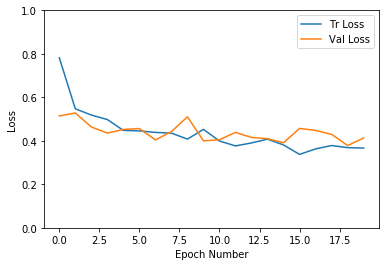

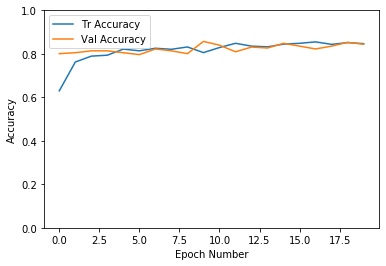

In [20]:

torch.save(history, 'F:\DataSets/modles/'+'resnet101' + '_history.pt')

history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.savefig('resnet101_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4]) 
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig('resnet101_accuracy_curve.png')
plt.show()